# Toy Example of OWAD

In this note, I'll showcase the usage of **OWAD** and validate the effectiveness with a toy example.
To help you understand the basic idea, I'll a synthetic dataset with a straightforward distribution.
Please note that the data distribution in a real-world case is much more complicated. 

**(1) First, import packages:**

In [1]:
%load_ext autoreload
%autoreload 2
## import packages
import sys
import warnings
warnings.filterwarnings('ignore')
sys.path.append('../admodels/')
sys.path.append('../moudles/')
sys.path.append('../baselines/')
sys.path.append('../')
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import _pickle as pkl
import AE

## import OWAD moudles
from calibrator import Calibrator
from shifthunter import ShiftHunter
import myutils as utils

**(2) Next, generate data in form of clusters. To make sure that you understand some terms in our study, we clarify that the dataset during handling concept drift can be split into two sets:**
- *Control set*: this set of data represent the *old* distribution, or the distribution that the model can currently fit
- *Treatment set*: this set of data represent the *new* distribuion. Treatment set is sampled in the current environment and you want to know whether the new distribution is drifted compared with the old distribution

To finish the shift detection (and possible explanation and adaptation if concept drift), you have to collect partial data in treatment set and compared them with control set.

In this toy example, we simulate a kind of concept dirft. The control set consists of 3 clusters, two of them are not shifted/drifted in the treatment set, while the third one changes to another cluster of data.

See the following figure, two unchanged clusters are in black color, the *no longer existed* cluster (in treatment set) is in blue, the newly appeared cluster is in orange. The anomalies are in red.

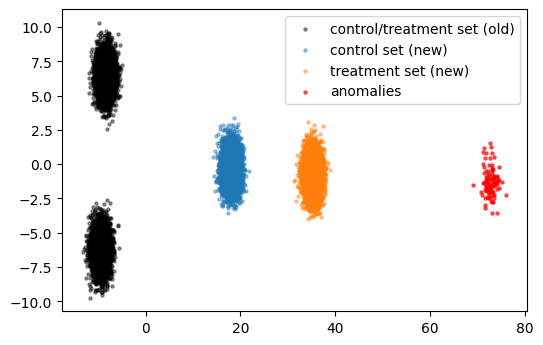

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.dpi':100})

from sklearn.datasets import make_blobs

X_c_old, _ = make_blobs(n_samples=10000, centers=2, n_features=100,
                  random_state=42,center_box=(0,3),shuffle=False) # cluster_std=1., 

X_c_new, _ = make_blobs(n_samples=5000, centers=1, n_features=100,
                  random_state=300, center_box=(3,5), shuffle=False) 

X_a, _ = make_blobs(n_samples=100, centers=1, n_features=100,
                  random_state=100, center_box=(8,12), ) # cluster_std=1., center_box=(6,7)

from sklearn.decomposition import PCA

X_c = np.concatenate((X_c_old, X_c_new))
pca = PCA(n_components=2, random_state=1).fit(X_c)
X_cp_old = pca.transform(X_c_old) 
X_cp_new = pca.transform(X_c_new)

plt.scatter(X_cp_old[:, 0], X_cp_old[:, 1], alpha=0.4, c='black', s=5, label="control/treatment set (old)")
plt.scatter(X_cp_new[:, 0], X_cp_new[:, 1], alpha=0.4, s=5, label="control set (new)")

X_t_new, _ = make_blobs(n_samples=5000, centers=1, n_features=100,
                  random_state=0, center_box=(5,7), )

X_t = np.concatenate((X_c_old,X_t_new), axis=0)
X_tp = pca.transform(X_t) 
X_tp_new = X_tp[10000:]

plt.scatter(X_tp_new[:, 0], X_tp_new[:, 1], alpha=0.4, s=5, label="treatment set (new)")

X_ap = pca.transform(X_a) 
plt.scatter(X_ap[:, 0], X_ap[:, 1], color='red', alpha=0.6, s=5, label="anomalies")

plt.legend()
plt.show()


**(3) Now let's assume we're at the very beginning. We only have the control set data and want to train an anomaly detection model.**

Here we train an autoencoder with normal data (we assume the control set and treatment set are all normal data).
Btw, the training procedure is to minimize the reconstruction error.

In [3]:
utils.set_random_seed()
X_train = X_c
model, thres = AE.train(X_train, X_train.shape[-1], lr=1e-3)

epoch:0/10 |Loss: 7.600680351257324
epoch:1/10 |Loss: 2.575716733932495
epoch:2/10 |Loss: 1.604437232017517
epoch:3/10 |Loss: 1.4883190393447876
epoch:4/10 |Loss: 1.4818185567855835
epoch:5/10 |Loss: 1.463930368423462
epoch:6/10 |Loss: 1.4745168685913086
epoch:7/10 |Loss: 1.4488450288772583
epoch:8/10 |Loss: 1.4506258964538574
epoch:9/10 |Loss: 1.432126522064209
max AD score 1.5402564
thres: 1.4428103


**(4) Let's test the performance of our anomaly model in the control set (i.i.d. setting).**

TPR>99%, FPR<1% AUC>99%, Seems great aha!

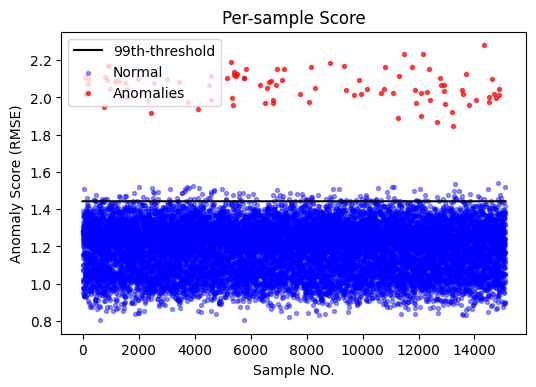

TPR: 0.999999999999 FPR: 0.009999999999999933
roc_auc: 0.9900000000000001


In [4]:
from sklearn.utils import shuffle
X_con_test = np.concatenate((X_c,X_a))
y_con_test = np.asarray([0]*15000+[1]*100)
X_con_test, y_con_test = shuffle(X_con_test, y_con_test)

pred_c, rmse_c = AE.test(model, thres, X_con_test)
AE.test_plot(rmse_c, thres, label=y_con_test)
utils.TPR_FPR(rmse_c, y_con_test, thres)
utils.multi_metrics(rmse_c, y_con_test, thres, plot_file=None)

**(5）Suppose after a period of time, we want to see if concept drift has occurred, we have collected some data now (exactly treatment set), let's see how the model works on the treatment set data.**

FPR > 22% AUC falls to 77% That's not good /(ㄒoㄒ)/~~

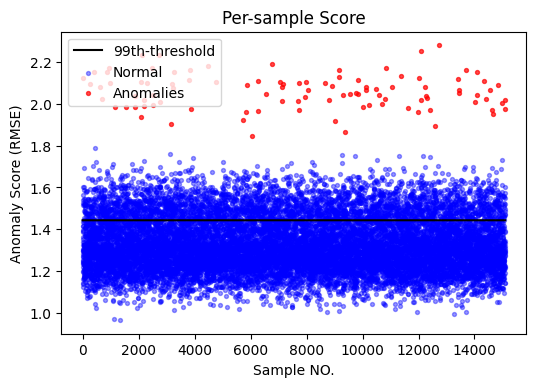

TPR: 0.999999999999 FPR: 0.2202666666666652
roc_auc: 0.7797333333333333


In [5]:
X_tre_test = np.concatenate((X_t,X_a))
y_tre_test = np.asarray([0]*15000+[1]*100)
X_tre_test, y_tre_test = shuffle(X_tre_test, y_tre_test)

pred_t, rmse_t = AE.test(model, thres, X_tre_test)
AE.test_plot(rmse_t, thres, label=y_tre_test)
utils.TPR_FPR(rmse_t, y_tre_test, thres)
utils.multi_metrics(rmse_t, y_tre_test, thres, plot_file=None)

## Time to let OWAD shine!
**(6) Let's first check whether distribution shift (concept drift) happens technically. You may think that the model perforemance degradation in the above experiment has verified the concept drift. That's right! However, there are two limitations of observing model performance to determine concept drift: the first is the observation requires labelling and the second is some drift does not necessarily affect the performance of the model. Therefore, OWAD uses a distributional hypothesis test. In short, you can get a confidence score (p-value) to determine whether shift or not. 
The smaller the p-value, the greater the probability of drift (common practice of threshold is 0.01 or 0.05).**

P-value is so small, we fully believe that drift has occurred!
We also visualize how data distribution shifts from control set to treatment set.

NOTICE: Initialize OWAD Calibrator Under **Isotonic** Method!
NOTICE: uncalibrated Probs is **MALICIOUS** confidence
NOTICE: Initilize OWAD Shift Handler Under **Tab** Mode!
Shift! P-value is 0.000999000999000999
Visualize Shift:


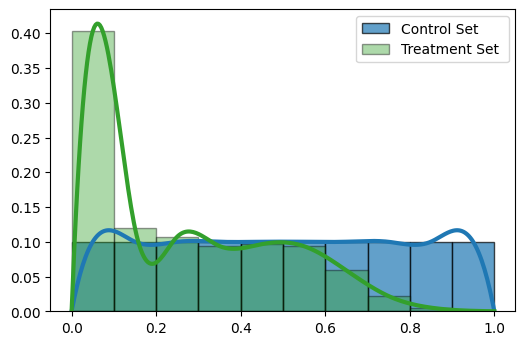

In [6]:
X_con, y_con = X_c, np.asarray([0]*15000)
X_tre, y_tre = X_t[::3], np.asarray([0]*5000)
_, rmse_c = AE.test(model, thres, X_con)
_, rmse_t = AE.test(model, thres, X_tre)

utils.set_random_seed()
cb = Calibrator(X_con, method='Isotonic')
cb.set_calibrator(rmse_c, is_P_mal=True)
sh = ShiftHunter(rmse_c, rmse_t, cb, ad_type='Tab')
t = utils.get_params('ShiftDetector')['test_thres']
p_value = sh.permu_test()
if p_value >= t:
    print("Non-shift, skip explain and adaptation!")
else:
    print('Shift! P-value is', p_value)
print("Visualize Shift:")
sh.visualize_hists()

**(7.1) Because the drift has occurred, we want to explain the drift, that is, we want to see which samples caused the drift. The  explaination of OWAD is a procedure to find more influential samples (for causing the drift) and at the same time we want to find less such samples to reduce labeling overhead (see the further step of shift adaptation, we need to label such samples before use them to retrain the model)**

This procedure is to solve an optimization problem. We omit technical details here. The following figures show the error between explanation set the treatment set, as well as the components of explanation set.

step:0 |Loss:21.0000 |Accuracy_Loss:1.0000 |Overhead_Loss:1.0000 |Determinism_Loss:1.0000 |M_c num: 7500 |M_t num: 2736
step:10 |Loss:16.8803 |Accuracy_Loss:0.7183 |Overhead_Loss:1.0257 |Determinism_Loss:0.9779 |M_c num: 7691 |M_t num: 2856
step:20 |Loss:14.9318 |Accuracy_Loss:0.5823 |Overhead_Loss:1.0516 |Determinism_Loss:0.9398 |M_c num: 8034 |M_t num: 2863
step:30 |Loss:13.5536 |Accuracy_Loss:0.4853 |Overhead_Loss:1.0764 |Determinism_Loss:0.8923 |M_c num: 8496 |M_t num: 2840
step:40 |Loss:12.6167 |Accuracy_Loss:0.4208 |Overhead_Loss:1.0887 |Determinism_Loss:0.8614 |M_c num: 8939 |M_t num: 2624
step:50 |Loss:11.7451 |Accuracy_Loss:0.3606 |Overhead_Loss:1.1037 |Determinism_Loss:0.8180 |M_c num: 9512 |M_t num: 2372
step:60 |Loss:10.9094 |Accuracy_Loss:0.3041 |Overhead_Loss:1.1140 |Determinism_Loss:0.7786 |M_c num: 9891 |M_t num: 2078
step:70 |Loss:9.9782 |Accuracy_Loss:0.2413 |Overhead_Loss:1.1253 |Determinism_Loss:0.7318 |M_c num: 10264 |M_t num: 1753
step:80 |Loss:9.2168 |Accuracy_Lo

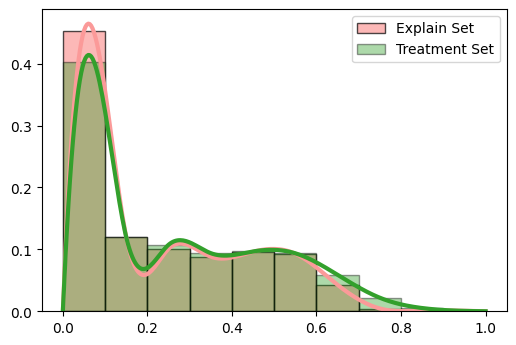

** Warning: No Need to Clip <remain_X_t> according to <label_num>
   (label_num:2000, remain_X_t:1301, X_t:5000)
NOTICE: simulating labelling...
Filter 0 anomalies in remain_X_tre
Remain X_c.shape (3886, 100) X_t.shape (1301, 100)


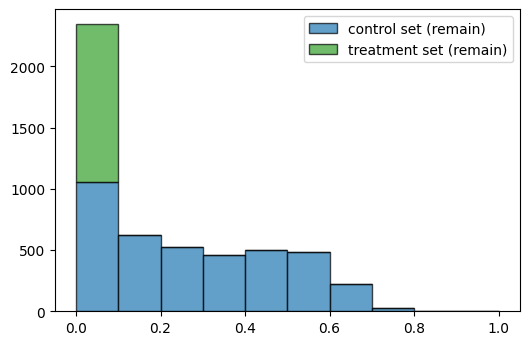

In [7]:
utils.set_random_seed()
ohd_bgt = 2000
exp_result = sh.explainer(X_tre, y_tre, label_num = ohd_bgt, 
                            lr=5., steps=100, plot_compose=True, 
                            acc_wgt = 15, ohd_wgt = 5, det_wgt = 1,) 

**(7.2) Let's validate the effectiveness of OWAD explanation. The explanation result can be like "some samples in control set *remain* normal, some samples in the control set are *no-longer* normal, some samples in treatment set *newly become* normal". In this simple example, we have a God's perspective: we know that the drift drifts because one cluster disappears, and the other cluster appears, let's check if owad can find this.**

See the following figure, 1197 samples of new cluster data is selected and the old (disappeared) cluster only has 100 samples left, and the old (remaining) two clusters are with 1825 and 1981 samples. 
This indicates OWAD explanation correctly explains the shift in the distribution!

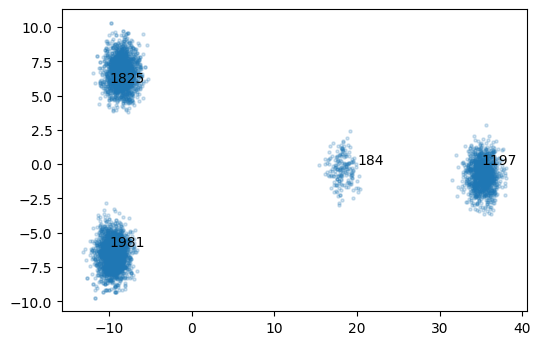

In [11]:
# exp_result

X_exp = np.concatenate((exp_result['remain_X_con'], exp_result['remain_X_tre']))
X_expp = pca.transform(X_exp) 

count = [0,0,0,0]
for x in X_expp:
    if  x[0]<0 and x[1]<0:
        count[0] += 1
    elif  x[0]<0 and x[1]>0:
        count[1] += 1
    elif x[0]<25:
        count[2] += 1
    elif x[0]<40:
        count[3] += 1
        
plt.scatter(X_expp[:, 0], X_expp[:, 1], alpha=0.2, s=5, label="exp_set")
plt.text(-10,-6, str(count[0]))
plt.text(-10,6, str(count[1]))
plt.text(20,0, str(count[2]))
plt.text(35,0, str(count[3]))
plt.show()

**(8) Now, the last but the most important step is to remedy our pool model. As mentioned above, the retrain the model with samples in the explanation set and test the performance in the treatment set after adapation. We also leverage some techniques to prevent forgetting useful knowledge of model during retraining.**

After adaptation, FPR reduce from 22% to 2%! AUC increase from 77% to 97%. Nice job, OWAD!  

Adapter: Begin Processing ... 
 Estimating Params Weight:0/519
epoch:0 ,step:0 |Distrib_Loss:1.8159 rmse_vec:1.3460
epoch:1 ,step:0 |Distrib_Loss:1.8146 rmse_vec:1.3427
epoch:2 ,step:0 |Distrib_Loss:1.8005 rmse_vec:1.3400
epoch:3 ,step:0 |Distrib_Loss:1.8110 rmse_vec:1.3373
epoch:4 ,step:0 |Distrib_Loss:1.7878 rmse_vec:1.3347
epoch:5 ,step:0 |Distrib_Loss:1.7902 rmse_vec:1.3322
epoch:6 ,step:0 |Distrib_Loss:1.7814 rmse_vec:1.3299
epoch:7 ,step:0 |Distrib_Loss:1.7579 rmse_vec:1.3276
epoch:8 ,step:0 |Distrib_Loss:1.7613 rmse_vec:1.3254
epoch:9 ,step:0 |Distrib_Loss:1.7415 rmse_vec:1.3231
epoch:10 ,step:0 |Distrib_Loss:1.7659 rmse_vec:1.3211
epoch:11 ,step:0 |Distrib_Loss:1.7428 rmse_vec:1.3192
epoch:12 ,step:0 |Distrib_Loss:1.7429 rmse_vec:1.3172
epoch:13 ,step:0 |Distrib_Loss:1.7380 rmse_vec:1.3153
epoch:14 ,step:0 |Distrib_Loss:1.7418 rmse_vec:1.3135
epoch:15 ,step:0 |Distrib_Loss:1.7282 rmse_vec:1.3117
epoch:16 ,step:0 |Distrib_Loss:1.7351 rmse_vec:1.3100
epoch:17 ,step:0 |Distrib_Los

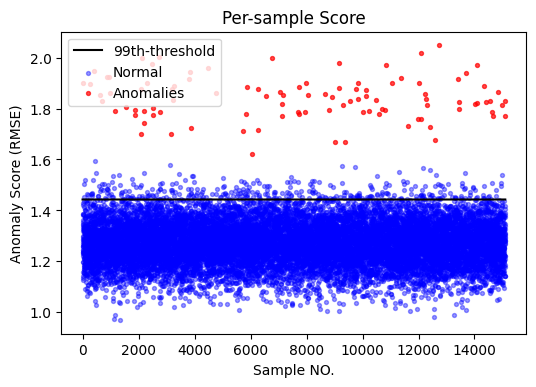

TPR: 0.999999999999 FPR: 0.023066666666666513
roc_auc: 0.9769333333333333


In [12]:
sh.adapter(model,lr=1e-3, steps=20)
y_pred, y_prob = AE.test(sh.model, thres, X_tre_test)
AE.test_plot(y_prob, thres, label=y_tre_test)
utils.TPR_FPR(y_prob, y_tre_test, thres)
utils.multi_metrics(y_prob, y_tre_test, thres, plot_file=None)

**(9) At last, I also want to highlight the motivation and advantages of OWAD compared to *direct retraining*， which is a common practice before OWAD. We retaining a new model with a combination of control set and treatment set and test the performance on the treatment set. As you can see in the following figure. The performance is pool. This is because direct retraining does not account for changes in the distribution of the data. Specficially in this toy example, it cannot forget that cluster that no longer occurs**

epoch:0/20 |Loss: 6.727018356323242
epoch:1/20 |Loss: 1.7138009071350098
epoch:2/20 |Loss: 1.5316787958145142
epoch:3/20 |Loss: 1.5025572776794434
epoch:4/20 |Loss: 1.4845983982086182
epoch:5/20 |Loss: 1.4697988033294678
epoch:6/20 |Loss: 1.4576255083084106
epoch:7/20 |Loss: 1.464561939239502
epoch:8/20 |Loss: 1.4725207090377808
epoch:9/20 |Loss: 1.4275678396224976
epoch:10/20 |Loss: 1.4033788442611694
epoch:11/20 |Loss: 1.3415591716766357
epoch:12/20 |Loss: 1.303009033203125
epoch:13/20 |Loss: 1.2838387489318848
epoch:14/20 |Loss: 1.2324923276901245
epoch:15/20 |Loss: 1.1541234254837036
epoch:16/20 |Loss: 1.143584966659546
epoch:17/20 |Loss: 1.0797313451766968
epoch:18/20 |Loss: 1.00639009475708
epoch:19/20 |Loss: 0.9856796264648438
max AD score 1.2502576
thres: 1.1581765
After Retraining:


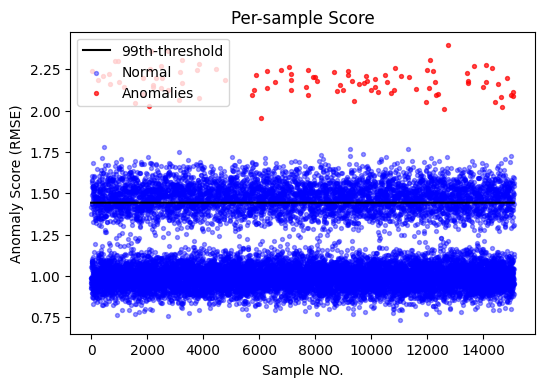

TPR: 0.999999999999 FPR: 0.21793333333333187
roc_auc: 0.7820666666666667


In [13]:
utils.set_random_seed()
X_retrain = np.concatenate((X_con,X_tre[:ohd_bgt]))
retrain_model, retrain_thres = AE.train(X_retrain, X_retrain.shape[-1], epoches=20, lr=1e-3)

## test the performance of retraining model
print('After Retraining:')
y_pred, y_prob = AE.test(retrain_model, thres, X_tre_test)
AE.test_plot(y_prob, thres, label=y_tre_test)
utils.TPR_FPR(y_prob, y_tre_test, thres)
utils.multi_metrics(y_prob, y_tre_test, thres, plot_file=None)